# Data 607 &mdash; Winter 2022 &mdash; Assignment 2

## Instructions

**Submit a .ipynb file and a Colab link to the your solutions to the appropriate D2L dropbox by 23:59 on Wednesday, March 23. For the Colab link, make sure that the permission is set to "Anyone on the internet with this link can view".**

## Authors:
    - Andrii Voitkiv, UCID: 30199373
    - Faraz Khan, UCID: 30146190

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Synthetic Dataset 1: Binary Classification

Here's some code for generating binary classification data with a nonlinear decision boundary:

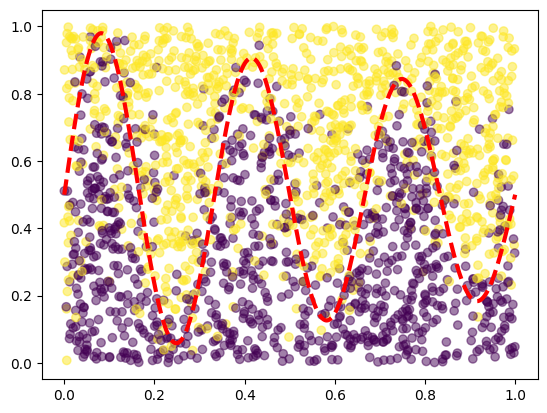

In [2]:
def make_two_class_data(n, random_state=None):
  def f(x):
    return 0.5*(np.sin(2*np.pi*3*x)*np.exp(-0.5*x) + 1)

  if random_state is not None:
    np.random.seed(42)

  X = np.random.uniform(size=(n, 2))
  e0 = 0.05*np.random.normal(size=n)
  e1 = 0.05*np.random.normal(size=n)
  y = X[:,1] + e1 > f(X[:,0] + e0)

  return X, y

X, y = make_two_class_data(2000, random_state=42)
plt.scatter(*X.T, c=y, alpha=0.5)
t = np.linspace(0, 1, 1000)
plt.plot(t, 0.5*(np.sin(2*np.pi*3*t)*np.exp(-0.5*t) + 1), "r--", lw=3)
plt.show()

## Synthetic Dataset 2: 3-Class Classification

Here's some code for generating 3-class classification data:

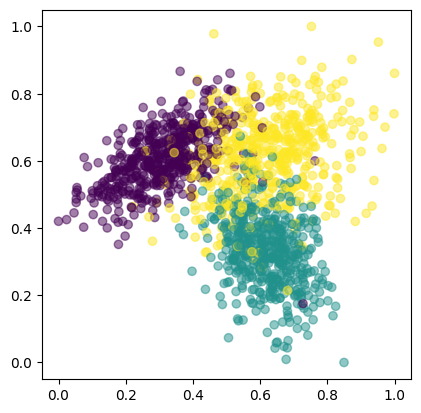

In [3]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

def make_three_class_data(n, random_state=None):
  X, y = make_classification(
      n_classes=3,
      n_samples=n,
      n_features=2,
      n_informative=2,
      n_redundant=0,
      n_clusters_per_class=1,
      class_sep=1.0,
      random_state=random_state)

  scaler = MinMaxScaler()
  X = scaler.fit_transform(X)
  return X, y

X, y = make_three_class_data(1500, random_state=43)
plt.scatter(*X.T, c=y, alpha=0.5)
plt.gca().set_aspect("equal")

## Exercise 1: Gaussian Bayes Classifier

1. Implement the Gaussian Bayes classifier (as described in Lecture 4) as a scikit-learn estimator by fleshing class skeleton included below.

  Your estimator should support $K$-class classification, not just binary classification.

In [18]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

class GaussianBayes(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        # your code here
        n_features = X.shape[1] # number of features
        n_classes = len(self.classes_) # number of unique classes

        # initialize the means, variances, and priors
        self.means_ = np.zeros((n_classes, n_features))
        self.vars_ = np.zeros((n_classes, n_features))
        self.priors_ = np.zeros(n_classes)
        # set the number of features
        # this is required for the check_estimator function
        self.n_features_in_ = X.shape[1]

        # iterate over each class
        # and compute the mean, variance, and prior
        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]
            self.means_[idx, :] = X_c.mean(axis=0)
            self.vars_[idx, :] = X_c.var(axis=0)
            self.priors_[idx] = X_c.shape[0] / float(X.shape[0])
        return self

    def predict(self, X):
        check_is_fitted(self) # ensures that the model has been trained
        X = check_array(X) # ensures that the input is a numpy array
        # your code here
        n_classes = len(self.classes_)
        posteriors = np.zeros((X.shape[0], n_classes)) # initialize the posteriors

        # iterate over each class
        # and compute the posterior
        for idx in range(n_classes):
            prior = self.priors_[idx]
            # Calculate the Gaussian probability density function (PDF):
            likelihood = -0.5 * np.sum(np.log(2.0 * np.pi * self.vars_[idx, :])) \
                         -0.5 * np.sum(((X - self.means_[idx, :]) ** 2) / self.vars_[idx, :], axis=1)
            posteriors[:, idx] = likelihood + np.log(prior)

        return self.classes_[np.argmax(posteriors, axis=1)]


In [19]:
check_estimator(GaussianBayes())


Start with the multivariate Gaussian distribution, which models the joint probability density function of $p$ features with a mean vector $\boldsymbol{\mu}$ and a covariance matrix $\boldsymbol{\Sigma}$:

$$
p(\mathbf{x})=\frac{1}{\sqrt{(2 \pi)^p|\boldsymbol{\Sigma}|}} \exp \left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1}(\mathbf{x}-\boldsymbol{\mu})\right)
$$
Where:

-   $\mathbf{x}$ is a $p$-dimensional data point
-   $p$ is the number of features
-   $\boldsymbol{\mu}$ is a $p$-dimensional mean vector
-   $\boldsymbol{\Sigma}$ is a $p \times p$ covariance matrix
-   $|\boldsymbol{\Sigma}|$ is the determinant of the covariance matrix

However, the Gaussian Bayes classifier assumes that the features are independent, and thus, the covariance matrix is diagonal. In this case, the multivariate Gaussian distribution can be factorized into a product of $p$ univariate Gaussian distributions:

$$
p(\mathbf{x})=\prod_{i=1}^p \frac{1}{\sqrt{2 \pi \sigma_i^2}} \exp \left(-\frac{1}{2} \frac{\left(x_i-\mu_i\right)^2}{\sigma_i^2}\right)
$$

Where:

-   $x_i$ is the $i$-th feature of the data point
-   $\mu_i$ is the mean of the $i$-th feature
-   $\sigma_i^2$ is the variance of the $i$-th feature

Taking the natural logarithm of this product of univariate Gaussian PDFs, we get:

$$
\log p(\mathbf{x})=\sum_{i=1}^p\left(-\frac{1}{2} \log \left(2 \pi \sigma_i^2\right)-\frac{\left(x_i-\mu_i\right)^2}{2 \sigma_i^2}\right)
$$

Now, the posterior probability is the likelihood multiplied by the prior probability and divided by the marginal likelihood (evidence). In the log domain, this is equivalent to adding the log-likelihood and log-prior:

$$
\log p\left(C_k \mid \mathbf{x}\right)=\log p\left(\mathbf{x} \mid C_k\right)+\log p\left(C_k\right)-\log p(\mathbf{x})
$$

The code snippet calculates the log-posterior for each Gaussian component (indexed by `idx`) and stores it in `posteriors[:, idx]`:

```python
posteriors[:, idx] = likelihood + np.log(prior)
```

This corresponds to the formula mentioned above. The marginal likelihood (evidence) is not included in this calculation, as it is the same for all components and does not affect the maximization of the posterior probabilities.

References: [1](https://static1.squarespace.com/static/5ae0d0b48ab7227d232c2bea/t/5de5b403ae38e01033f5cf38/1575334918495/mle.pdf)

2. Apply your `GaussianBayes` estimator to Synthetic Dataset 2: Fit your model to the training data and predict class labels for the testing data. (Use the data splitting provided below.) Plot the decision regions, overlaid with the a scatter plot of the dataset.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X, y = make_three_class_data(1500, random_state=44)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.8, random_state=45)

gb = GaussianBayes()
gb.fit(X_tr, y_tr)
y_pred = gb.predict(X_te)

print(f"Accuracy: {accuracy_score(y_te, y_pred)}")

Accuracy: 0.7925


3. Repeat part 2. with `sklearn.naive_bayes.GaussianNB` in place of your own `GaussianBayes`.

In [21]:
from sklearn.naive_bayes import GaussianNB

# Instantiate the GaussianNB classifier instead of GaussianBayes
gnb = GaussianNB()
gnb.fit(X_tr, y_tr)
y_pred = gnb.predict(X_te)

print(f"Accuracy: {accuracy_score(y_te, y_pred)}")

Accuracy: 0.7925


## Exercise 2: Kernel Classification

Let $W(x,x_i)$ be a weight function, as in our discussion of kernel regression from Lecture 4.

Suppose we're given training data for a $K$-class classification problem,

$$
(x_1,y_1),\ldots,(x_n,y_n),
$$

where $x_i\in\mathbb{R}^p$ and $y_i\in\{0,\ldots,K-1\}$.

For each test point $x\in\mathbb{R}^p$ and each class $k\in\{0,\ldots,K-1\}$, let $W_k(x)$ be the sum of the weights $W(x,x_i)$ associated to training examples $(x_i, y_i)$ with $y_i=k$:

$$
W_k(x) = \sum_{\begin{smallmatrix}i=1\\ y_i=k\end{smallmatrix}}^n W(x,x_i)
$$

Define a corresponding classification rule by assigning $x$ to the class $k$ for which $W_k(x)$ is largest:

$$
f(x) = \operatorname*{arg\,max}_{0\leq k<K} W_k(x)
$$

This entire discussion applies when the weight function $W(x,x_i)$ arises from a kernel function $K$ and a bandwidth parameter $h$, as in Lecture 4:

$$
W(x, x_i) = \frac{K(\|x - x_i\|/h)}{\sum_{j=1}^n K(\|x - x_j\|/h)}
$$

The resulting classifier is called a **kernel classifier**.

1. Implement the kernel classifier as a scikit-learn estimator by fleshing out the `predict` method of the class skeleton included below. (Don't touch the `__init__` and `fit` methods.) Your classifier should pass the `check_estimator` test. Two bonus points if you can do this without using loops or their close cousins (e.g., comprehensions).

In [22]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.estimator_checks import check_estimator
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels

def G(x):
  return np.exp(-x**2/2)/np.sqrt(2*np.pi)

class KernelClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, K=G, h=1):
        self.K = K
        self.h = h

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.X_ = X
        self.y_ = y
        self.classes_ = unique_labels(y)
        self.n_features_in_ = X.shape[1]
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        # your code here
        # check that the number of features in X matches the number of features in fit
        # this is required by scikit-learn
        if X.shape[1] != self.n_features_in_:
            raise ValueError("The number of features in predict is different from the number of features in fit.")
        # Compute pairwise distances between test points and training points
        dists = np.linalg.norm(self.X_.reshape(-1, 1, self.n_features_in_) - X.reshape(1, -1, self.n_features_in_), axis=2)

        # Apply the kernel function and normalize by bandwidth
        kernel_vals = self.K(dists / self.h)

        # Compute weights for each class
        weights = np.array([kernel_vals[self.y_ == c].sum(axis=0) for c in self.classes_])

        # Predict the class with the highest weight
        return self.classes_[np.argmax(weights, axis=0)]

check_estimator(KernelClassifier())

2. Apply your code to Synthetic Dataset 1. Use `GridSearchCV` on to find optimal values for the bandwidth parameter $h$. For that value of $h$, plot the decision regions and report the error on the test set.

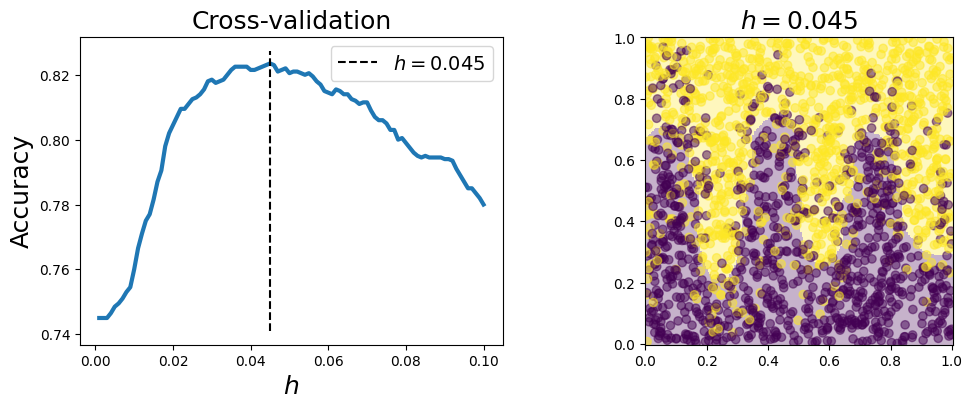

Error on test set: 0.165


In [28]:
from sklearn.model_selection import GridSearchCV

# Generate training and test data
X_tr, y_tr = make_two_class_data(2000, random_state=46)
X_te, y_te = make_two_class_data(2000, random_state=47)

# Find optimal value of h
hs = np.arange(0.001, 0.101, 0.001)

param_grid = {"h": hs}
search = GridSearchCV(KernelClassifier(), param_grid=param_grid, scoring="accuracy", cv=5)
search.fit(X_tr, y_tr)
h = search.best_params_["h"]
model = search.best_estimator_

def make_decision_regions(x=None, y=None, model=None):
    '''Make a grid of points and predict the class at each point.'''
    X, Y = np.meshgrid(x, y)
    XY = np.array([X.ravel(), Y.ravel()]).T #numpy.ravel() Return a contiguous flattened array.
    assert XY.shape == (len(x)*len(y), 2)
    Z = model.predict(XY).reshape(X.shape)
    return X, Y, Z

# Plot the cross-validation results and the decision regions
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

ax0.plot(hs, search.cv_results_["mean_test_score"], lw=3)
ax0.plot([h, h], ax0.get_ylim(), "k--", label=f"$h={h}$")
ax0.set_xlabel("$h$", fontsize=18)
ax0.set_ylabel("Accuracy", fontsize=18)
ax0.legend(fontsize=14, loc="upper right")
ax0.set_title("Cross-validation", fontsize=18)
y0, y1 = ax0.get_ylim()

U, V, W = make_decision_regions(x=np.linspace(0, 1, 200), y=np.linspace(0, 1, 200), model=model)
ax1 = plt.gca() #Get the current Axes.
ax1.pcolormesh(U, V, W, shading="auto", alpha=0.3)
ax1.scatter(*X_te.T, c=y_te,alpha=0.5)
ax1.set_aspect("equal")
ax1.set_title(f"$h={h}$", fontsize=18)

plt.show()

# Report the error on the test set
print(f"Error on test set: {1 - model.score(X_te, y_te):.3f}")

3. Apply your code to Synthetic Dataset 2. Use `GridSearchCV` on to find optimal values for the bandwidth parameter $h$. For that value of $h$, plot the decision regions and report the error on the test set.

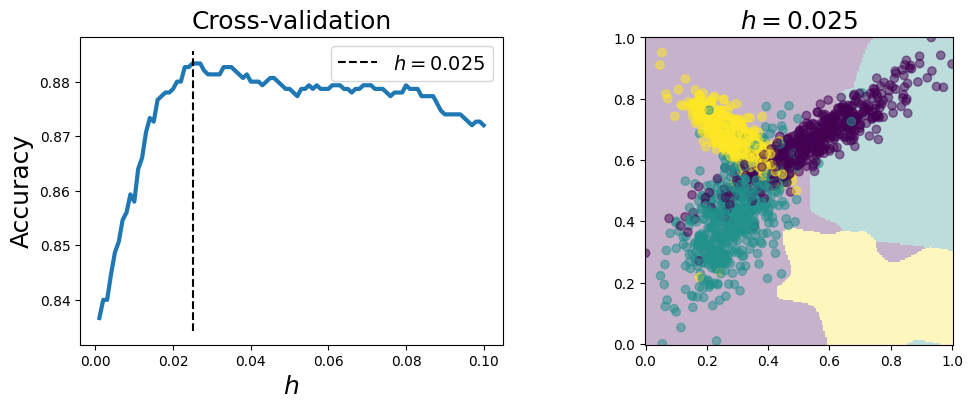

Error on test set: 0.781


In [29]:
from sklearn.model_selection import GridSearchCV


X_tr, y_tr = make_three_class_data(1500, random_state=48)
X_te, y_te = make_three_class_data(1500, random_state=49)


# Find optimal value of h
hs = np.arange(0.001, 0.101, 0.001)

param_grid = {"h": hs}
search = GridSearchCV(KernelClassifier(), param_grid=param_grid, scoring="accuracy", cv=5)
search.fit(X_tr, y_tr)
h = search.best_params_["h"]
model = search.best_estimator_

def make_decision_regions(x=None, y=None, model=None):
    '''Make a grid of points and predict the class at each point.'''
    X, Y = np.meshgrid(x, y)
    XY = np.array([X.ravel(), Y.ravel()]).T #numpy.ravel() Return a contiguous flattened array.
    assert XY.shape == (len(x)*len(y), 2)
    Z = model.predict(XY).reshape(X.shape)
    return X, Y, Z

# Plot the cross-validation results and the decision regions
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

ax0.plot(hs, search.cv_results_["mean_test_score"], lw=3)
ax0.plot([h, h], ax0.get_ylim(), "k--", label=f"$h={h}$")
ax0.set_xlabel("$h$", fontsize=18)
ax0.set_ylabel("Accuracy", fontsize=18)
ax0.legend(fontsize=14, loc="upper right")
ax0.set_title("Cross-validation", fontsize=18)
y0, y1 = ax0.get_ylim()

U, V, W = make_decision_regions(x=np.linspace(0, 1, 200), y=np.linspace(0, 1, 200), model=model)
ax1 = plt.gca() #Get the current Axes.
ax1.pcolormesh(U, V, W, shading="auto", alpha=0.3)
ax1.scatter(*X_te.T, c=y_te,alpha=0.5)
ax1.set_aspect("equal")
ax1.set_title(f"$h={h}$", fontsize=18)

plt.show()

# Report the error on the test set
print(f"Error on test set: {1 - model.score(X_te, y_te):.3f}")

## Exercise 3: Spam Detection

- In this exercise, we use Bayes and na&iuml;ve Bayes classifiers to classify text message spam.

- We use a dataset from the UCI machine learning repository. Details can be found here [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection).

- For our convenience, I'm hosting the data file on my github page.

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

url = "https://raw.githubusercontent.com/mgreenbe/spam/main/spam.csv"
df = pd.read_csv(url, encoding="latin-1") 
df.rename(columns={"v1": "label", "v2": "message"}, inplace=True)
df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


1. Split the data into a training set (80% of the data) and a testing set (20% of the data). Compute the proportions of ham and spam in the training set.

2. Add a feature column **length** to the dataframe `df` containing the lengths of the messages, in characters. Classify the messages in the test set as ham/spam using a Gaussian (na&iuml;ve) Bayes classifier trained on the length data. Record the associated testing error.

  Repeat this exercise with **caps**, the number of capital letters in a message, and **misc**, the number of characters in a message that aren't letters, digits, or spaces.

  (Since each of the classifiers in this part only considers a single feature, there is no distinction between Bayes and na&iuml;ve Bayes.)

3. Construct a **Gaussian na&iuml;ve Bayes** classifier to the (**length**, **caps**, **misc**) data. Compare its performance to those considered in part (2).

4. Construct a **Gaussian Bayes** classifier by fitting a 3-dimensional Gaussian distribution to the (**length**, **caps**, **misc**) data. Feel free to use your above implementation of `GaussianBayes` here. Compare its performance to the na&iuml;ve version considered in part (3). Comment.

5. Repeat part (2) with **digits**, the number of digits in a message. Comment.

6. Construct a **multinomial na&iuml;ve Bayes** classifier using frequency data as produced by `CountVectorizer`. Compare its performance to those considered above.

In [123]:
# Ans to Q1 
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['label'], test_size=0.2, random_state=42)

# Compute proportions of ham and spam in training set
train_df = pd.concat([X_train, y_train], axis=1)
ham_count = len(train_df[train_df['label']=='ham'])
spam_count = len(train_df[train_df['label']=='spam'])
ham_proportion = ham_count / len(train_df)
spam_proportion = spam_count / len(train_df)
print("Proportion of ham messages in training set:", ham_proportion)
print("Proportion of spam messages in training set:", spam_proportion)

Proportion of ham messages in training set: 0.8660533991474085
Proportion of spam messages in training set: 0.13394660085259144


In [122]:
# Ans to Q2 & Q5 
# Add feature columns
df['length'] = df['message'].apply(len)
df['caps'] = df['message'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['misc'] = df['message'].apply(lambda x: sum(1 for c in x if not (c.isalpha() or c.isdigit() or c.isspace())))
df['digits'] = df['message'].apply(lambda x: sum(c.isdigit() for c in x))

# Train/test Gaussian Naïve Bayes classifier on length
X_train, X_test, y_train, y_test = train_test_split(df['length'], df['label'], test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train.values.reshape(-1,1), y_train)
score = model.score(X_test.values.reshape(-1,1), y_test)
print("Length model testing error:", 1 - score)

# Train/test Gaussian Naïve Bayes classifier on caps
X_train, X_test, y_train, y_test = train_test_split(df['caps'], df['label'], test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train.values.reshape(-1,1), y_train)
score = model.score(X_test.values.reshape(-1,1), y_test)
print("Caps model testing error:", 1 - score)

# Train/test Gaussian Naïve Bayes classifier on misc
X_train, X_test, y_train, y_test = train_test_split(df['misc'], df['label'], test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train.values.reshape(-1,1), y_train)
score = model.score(X_test.values.reshape(-1,1), y_test)
print("Misc model testing error:", 1 - score)

# Train a Gaussian Naïve Bayes classifier on digits
X_train, X_test, y_train, y_test = train_test_split(df['digits'], df['label'], test_size=0.2, random_state=42)
model = GaussianNB()
model.fit(X_train.values.reshape(-1,1), y_train)
score = model.score(X_test.values.reshape(-1,1), y_test)
print("digits model testing error:", 1 - score)

Length model testing error: 0.13452914798206284
Caps model testing error: 0.1381165919282511
Misc model testing error: 0.13452914798206284
digits model testing error: 0.022421524663677084


In [115]:
# Ans to Q3 
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

# Add a column for length to the dataframe
df["length"] = df["message"].apply(len)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[["length", "caps", "misc"]], df["label"], test_size=0.2, random_state=42
)

# Fit a Gaussian Naive Bayes classifier to the length data
gnb = GaussianNB()
gnb.fit(X_train[["length"]], y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test[["length"]])

# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("Testing error for Gaussian naive Bayes classifier with (length, cap, misc) data:", 1 - gnb.score(X_test, y_test))

Accuracy: 0.865
Testing error for Gaussian naive Bayes classifier with (length, cap, misc) data: 0.13452914798206284


In [101]:
# Ans to Q4 
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

# Add columns for length, caps, and misc to the dataframe
df["length"] = df["message"].apply(len)
df["caps"] = df["message"].apply(lambda x: sum(1 for c in x if c.isupper()))
df["misc"] = df["message"].apply(lambda x: sum(1 for c in x if not c.isalnum() and not c.isspace()))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[["length", "caps", "misc"]], df["label"], test_size=0.2, random_state=42
)

# Construct a 3D feature matrix with columns for length, caps, and misc
X_train_3d = np.column_stack((X_train["length"], X_train["caps"], X_train["misc"]))
X_test_3d = np.column_stack((X_test["length"], X_test["caps"], X_test["misc"]))

# Fit a Gaussian Naive Bayes classifier to the 3D data
gnb = GaussianNB()
gnb.fit(X_train_3d, y_train)

# Make predictions on the test set
y_pred = gnb.predict(X_test_3d)

# Compute the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")
print("Testing error for Gaussian Bayes classifier with (length, caps, misc) data:", 1 - gnb.score(X_test, y_test))

Accuracy: 0.910
Testing error for Gaussian Bayes classifier with (length, caps, misc) data: 0.08968609865470856


In [119]:
# Ans to Q5 one more time 
df["digits"] = df["message"].apply(lambda x: sum([1 for char in x if char.isdigit()]))
X_train, X_test, y_train, y_test = train_test_split(df[["digits"]], df["label"], test_size=0.2, random_state=42)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print("Testing error with only the `digits` feature:", 1 - gnb.score(X_test, y_test))

Testing error with only the `digits` feature: 0.022421524663677084


In [113]:
# Ans to Q6
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["message"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
print("Testing error with `CountVectorizer` and a multinomial naive Bayes classifier:", 1 - mnb.score(X_test, y_test))

Testing error with `CountVectorizer` and a multinomial naive Bayes classifier: 0.021524663677130018


Classified the messages in the test set as ham/spam using a Gaussian Naive Bayes classifier trained on each of the individual features.
The testing error rates for each classifier were:
- Length model testing error: 0.13452914798206284
- Caps model testing error: 0.1381165919282511
- Misc model testing error: 0.13452914798206284
- Digits model testing error: 0.022421524663677084

In part 3: we used the Gaussian Naive Bayes classifier with (length, cap, misc) data.
- with Accuracy: 0.865 and Testing error for Gaussian naive Bayes classifier with (length, cap, misc) data: 0.13452914798206284

In part 4: we used the Gaussian Bayes classifier by fitting a 3-dimensional Gaussian distribution to the (length, caps, misc) data.
- with Accuracy: 0.910 and Testing error for Gaussian Bayes classifier with (length, caps, misc) data: 0.08968609865470856

The Gaussian Bayes classifier performed slightly better than the Gaussian Naive Bayes classifier with (length, cap, misc) data, which suggests that there may be some correlation between the features.



In part 6 we used CountVectorizer to transform the messages into a frequency matrix.
- The testing error rate for this classifier was 0.0215.

The multinomial Naive Bayes classifier with CountVectorizer performed the best among all the classifiers considered.

In [2]:
from sklearn.datasets import fetch_covtype
covtype = fetch_covtype(as_frame=True)

In [2]:
# Check unique values in the "Elevation" variable
len(covtype.data["Elevation"].unique())

1978

<AxesSubplot: >

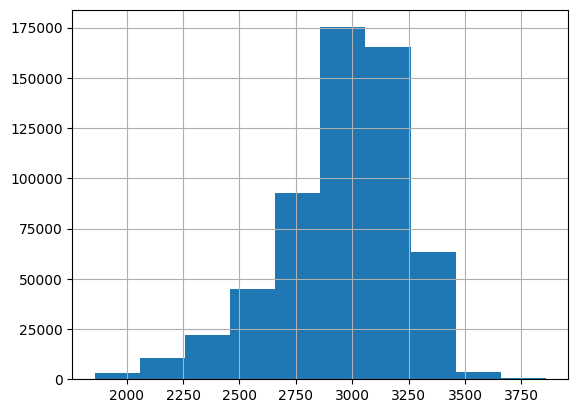

In [3]:
# Histogram of the "Elevation" variable
covtype.data["Elevation"].hist()